<a href="https://colab.research.google.com/github/Dinuka-1999/EN4553_MV_assignment/blob/Uvin/Qb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.68.15.26:8470']


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
data_augmentation=keras.Sequential([
    layers.RandomContrast(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2)
])

In [ ]:
#tfds.disable_progress_bar()
train_60,val_20,test_20=tfds.load("oxford_iiit_pet",split=["train","test[:50%]","test[50%:]"],as_supervised=True,shuffle_files=True,data_dir="gs://dinuka_bucket")

In [ ]:
resizing=layers.Resizing(224,224)
train_60=train_60.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf.data.AUTOTUNE)
val_20=val_20.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf.data.AUTOTUNE)
test_20=test_20.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf.data.AUTOTUNE)

train_60_1=train_60.map(lambda x,y:(data_augmentation(x,training=True),y),num_parallel_calls=tf.data.AUTOTUNE)

train_60_1=train_60.concatenate(train_60_1).shuffle(1000)

batch_size = 128

train_60_1= train_60_1.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()  # only to Fine tune the model

train_60 = train_60.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
val_20 = val_20.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_20 = test_20.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
# train,test=tfds.load("oxford_iiit_pet",split=["train","test"],as_supervised=True)

# resizing=layers.Resizing(224,224)
# train=train.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf.data.AUTOTUNE)
# test=test.map(lambda x,y:(resizing(x),y),num_parallel_calls=tf.data.AUTOTUNE)

# train_1=train.map(lambda x,y:(data_augmentation(x,training=True),y),num_parallel_calls=tf.data.AUTOTUNE)

# train=train.concatenate(train_1).shuffle(1000)

# batch_size = 128

# train = train.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
# test = test.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
# F10_train=tfds.load("oxford_iiit_pet",split=[f"train[:{r}%]+train[{r+10}%:]" for r in range(0,100,10)],as_supervised=True)
# F10_val=tfds.load("oxford_iiit_pet",split=[f"train[{r}%:{r+10}%]" for r in range(0,100,10)],as_supervised=True)

## Model

In [ ]:
def create_model(base_model,lr,wd):
  inputs=keras.Input(shape=(224,224,3))
  preprocessing=tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
  x=base_model(preprocessing, training=False)
  x=layers.Dense(256,activation="swish")(x)
  x=layers.Dropout(0.5)(x)
  outputs=layers.Dense(37)(x)

  model=keras.Model(inputs,outputs)
  loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizers=keras.optimizers.Adam(learning_rate=lr,weight_decay=wd)

  model.compile(optimizer=optimizers,loss=loss_fn,metrics=[keras.metrics.SparseTopKCategoricalAccuracy( k=1, name="accuracy")])
  return model

In [ ]:
with tpu_strategy.scope():
  base_model=keras.applications.MobileNetV2(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling="avg")
  base_model.trainable=False
  model=create_model(base_model,lr=0.002,wd=0.0005)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         Y          
 )                                                                          
                                                                            
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         Y          
 a)                                                                         
                                                                            
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   N          
 ional)                                                                     
                                                             

learning rate, weight decay, batch size, model

training acc, val acc, test acc(most important), top 1 , top 3

In [ ]:
callback=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
history=model.fit(train_60,epochs=2,validation_data=val_20)

Epoch 1/2
29/29 [==============================] - 29s 473ms/step - loss: 1.2234 - accuracy: 0.6633 - val_loss: 0.4178 - val_accuracy: 0.8577
Epoch 2/2
29/29 [==============================] - 3s 109ms/step - loss: 0.3314 - accuracy: 0.8992 - val_loss: 0.3680 - val_accuracy: 0.8779


In [ ]:
model.evaluate(test_20)

15/15 [==============================] - 3s 47ms/step - loss: 0.3239 - accuracy: 0.8975


[0.3238573968410492, 0.8975476622581482]

In [ ]:
model.save_weights('model.weights.h5')
model.save('model.keras')

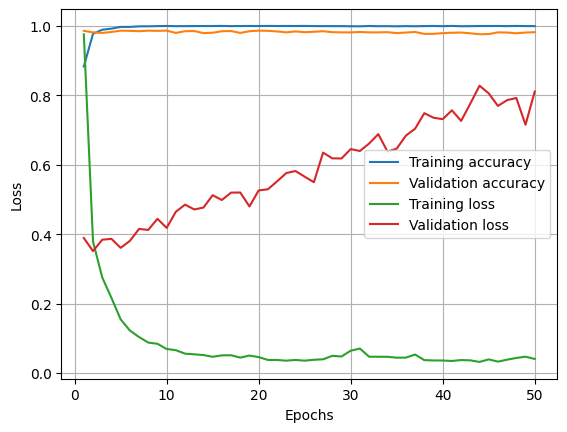

<Figure size 640x480 with 0 Axes>

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(6, 6))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('books_read.png')


## Fine tune

In [ ]:
base_model.trainable=True

In [ ]:
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         Y          
 )                                                                          
                                                                            
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         Y          
 a)                                                                         
                                                                            
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   Y          
 ional)                                                                     
                                                             

In [ ]:
with tpu_strategy.scope():
  loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizers=keras.optimizers.Adam(learning_rate=0.000001,weight_decay=0.00000001)

  model.compile(optimizer=optimizers,loss=loss_fn,metrics=[keras.metrics.SparseTopKCategoricalAccuracy( k=1, name="accuracy")])

In [ ]:
callback=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
history=model.fit(train_60,epochs=14,validation_data=val_20)

In [ ]:
model.evaluate(test_20)

15/15 [==============================] - 2s 53ms/step - loss: 0.3026 - accuracy: 0.9128


[0.3025510907173157, 0.912806510925293]